**Project objective:**
Classify survival of titanic passengers based upon given features

**Problem type:** 
Binary classification - Survived(1)/Killed(0)

**Performance Measure:**
Accuracy

**IMPORTS**

In [1]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
%matplotlib inline
import string
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# Model Functions

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


def model_eval(clf, data, labels):

    # Confusion matrix
    predict = cross_val_predict(clf, data, labels, cv=3)
    print('\033[1m'+"Model Confusion Matrix:\n" + '\033[0m')
    print(confusion_matrix(labels, predict))

    #Precision and Recall
    print('\033[1m'+"\nModel Precision:\n" + '\033[0m')
    precision = precision_score(labels, predict)
    print(precision)
    print('\033[1m'+"\nModel Recall:\n" + '\033[0m')
    recall = recall_score(labels, predict)
    print(recall)
    
    # Accuracy
    print('\033[1m'+"\nModel Accuracy:\n" + '\033[0m')
    accuracy = cross_val_score(clf, data, labels, cv=3, scoring="accuracy")
    print(accuracy.mean())

    print('\033[1m'+"\nModel Precision/Recall threshold Curve:\n" + '\033[0m')
    if clf == RndFrst_clf or clf == NB_clf or clf == MLP_clf:
        probas = cross_val_predict(
            clf, data, labels, cv=3, method='predict_proba')
        scores = probas[:, 1]
    else:
        scores = cross_val_predict(
            clf, data, labels, cv=3, method='decision_function')

    # Precision/Recall threshold Curve
    precisions, recalls, thresholds = precision_recall_curve(labels, scores)
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    plt.show()

    # Precision vs Recall Curve
    print('\033[1m'+"\nModel Precision vs Recall Curve:\n" + '\033[0m')
    plt.plot(precisions, recalls)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    # ROC Curve and Score
    print('\033[1m'+"\nModel ROC Curve and Score:\n" + '\033[0m')
    fpr, tpr, threshold = roc_curve(labels, scores)
    plot_roc_curve(fpr, tpr)
    plt.show()
    auc_score = roc_auc_score(labels, scores)
    print('\033[1m'+'\nROC AUC score:' +
          '\033[0m', auc_score)

    # Save evaluation data
    mean_acc = accuracy.mean()
    model_info = [precision, recall, accuracy.mean(),auc_score]  
    
    return mean_acc

**DATA DISCOVERY**

In [2]:
train = pd.read_csv('train.csv', sep=',')
train_c = train    #Copy of original training data
test = pd.read_csv('test.csv',sep=',')
test_c = test    #Copy of original test data
print(train.shape)

(891, 12)


In [3]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<function matplotlib.pyplot.show(*args, **kw)>

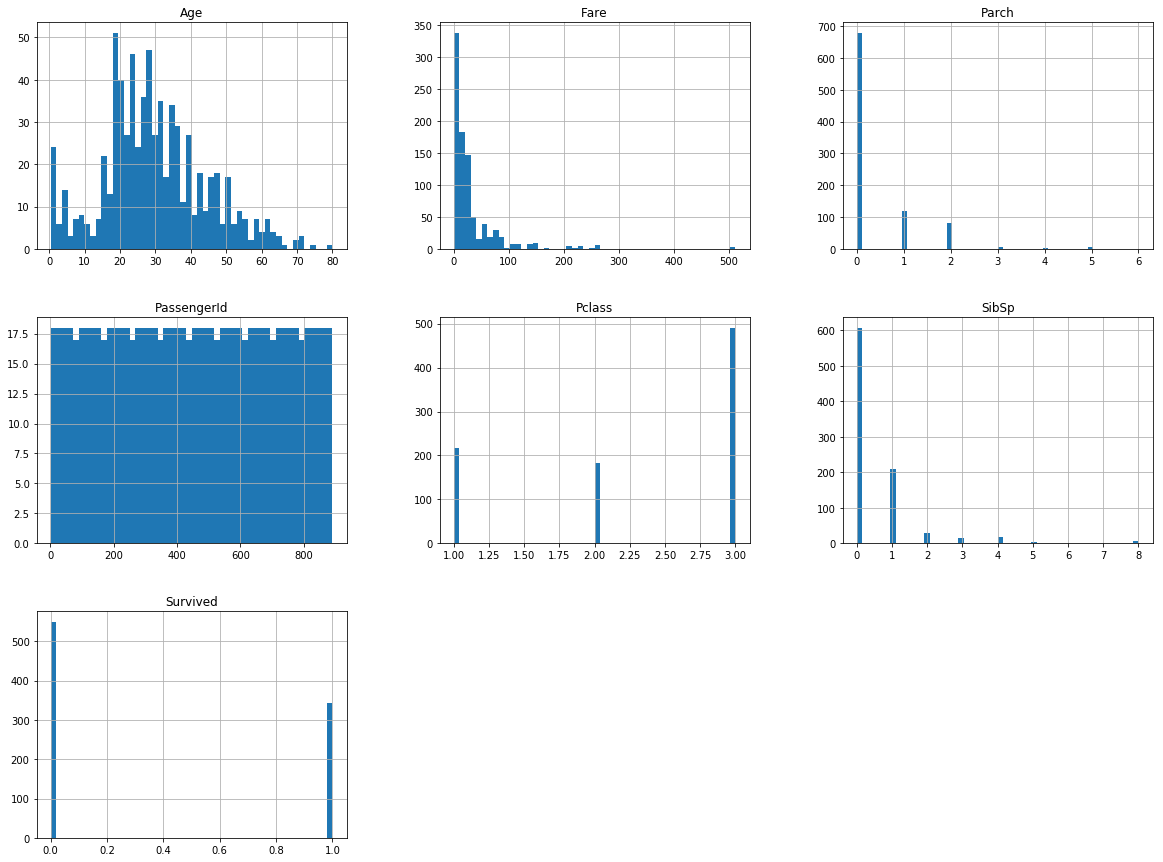

In [6]:
train.hist(bins=50, figsize=(20, 15))
plt.show

In [7]:
train.loc[825:900,:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
825,826,0,3,"Flynn, Mr. John",male,NaN,0,0,368323,6.9500,NaN,Q
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
827,828,1,2,"Mallet, Master. Andre",male,1.00,0,2,S.C./PARIS 2079,37.0042,NaN,C
828,829,1,3,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.00,0,0,113572,80.0000,B28,NaN
830,831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.00,1,0,2659,14.4542,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S
832,833,0,3,"Saad, Mr. Amin",male,NaN,0,0,2671,7.2292,NaN,C
833,834,0,3,"Augustsson, Mr. Albert",male,23.00,0,0,347468,7.8542,NaN,S
834,835,0,3,"Allum, Mr. Owen George",male,18.00,0,0,2223,8.3000,NaN,S


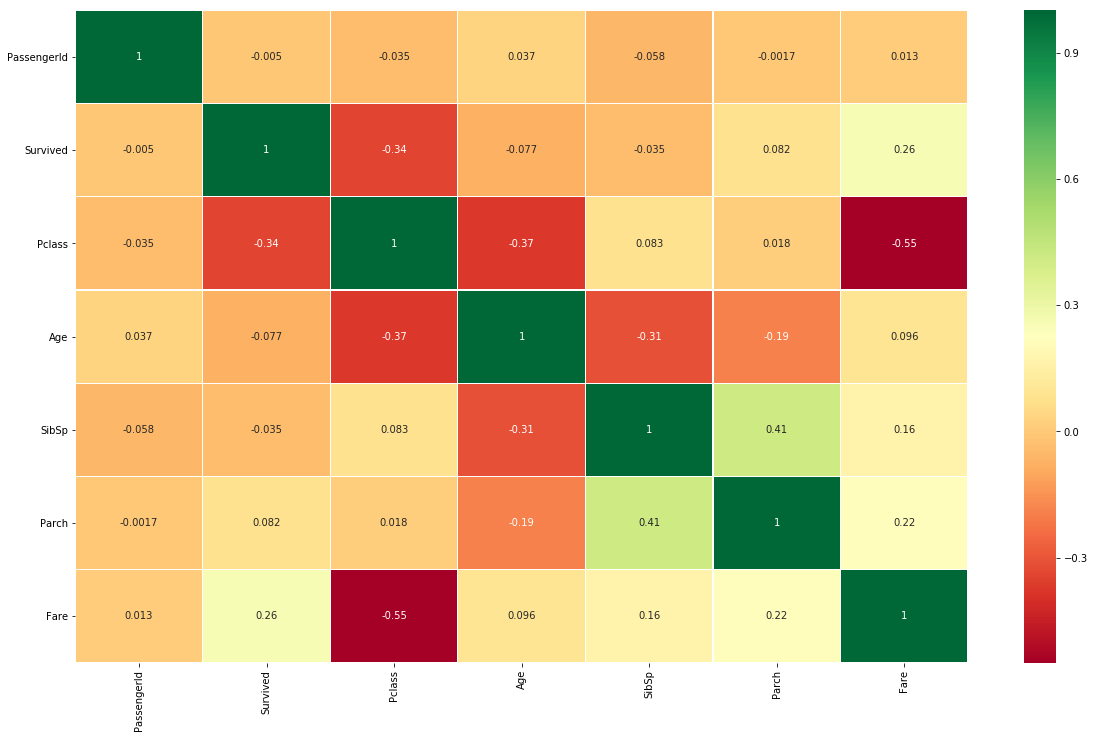

In [8]:
sns.heatmap(train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

**Notes:**

The following attributes currently look useless:
    * Name, Ticket, Cabin

The dataset includes text attributes - Name, Sex, Ticket, Cabin, Embarked
    * Sex -> binary feature
    * Embarked -> Multi-class feature
      
These will have to be turned into numerical attributes

The following attributes have missing values:
    * Age, Cabin, Embarked

Also note the difference in class sizes

Next: 
    * Remove 'useless' attributes
    * Turn text attributes sex and embarked into numerical attributes,
    * work with missing values

**DATA CLEANING**

In [9]:
#Split features and labels
train_labels = train['Survived']
train = train.drop('Survived',axis=1)

In [10]:
def phase1cleaning(data):

    # Drop 'useless' attributes
    data = data.drop(["Name", "Ticket", "Cabin",'PassengerId'],
                     axis=1)    # Drop 'useless' attributes
    # Fill missing values
    data['Age'].fillna(data['Age'].mean(), inplace=True)
    data['Fare'].fillna(data['Fare'].mean(), inplace = True)
    
    # One hot encode multi-label attributes
    data = pd.get_dummies(
        data, columns=["Sex", "Embarked"], prefix=["Sex", "Port"])
    
    return data

In [11]:
train = phase1cleaning(train)

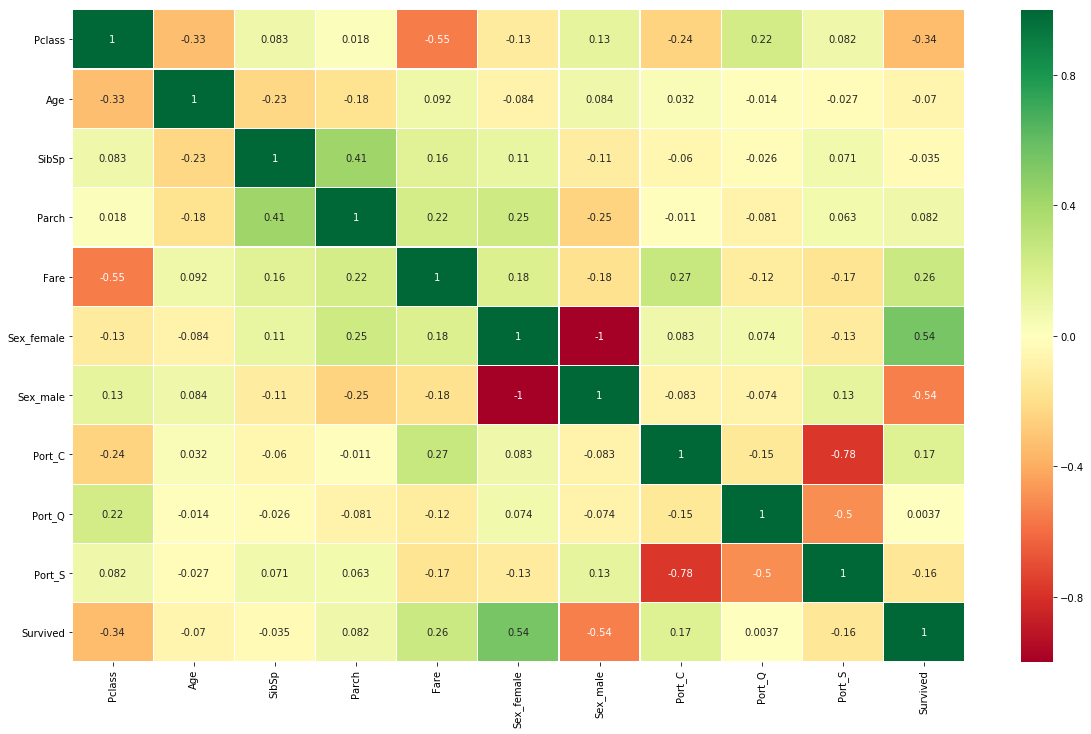

In [12]:
train_show = train.join(train_c['Survived'])
sns.heatmap(train_show.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [13]:
train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Pclass        891 non-null int64
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Sex_female    891 non-null uint8
Sex_male      891 non-null uint8
Port_C        891 non-null uint8
Port_Q        891 non-null uint8
Port_S        891 non-null uint8
dtypes: float64(2), int64(3), uint8(5)
memory usage: 39.2 KB


In [15]:
#Scale data
train_pp = train
scaler = StandardScaler()
train_pp_scaled = scaler.fit_transform(train_pp)

c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


**TRAIN AND EVALUATE MODELS**

c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol 

Model Confusion Matrix:

[[407 142]
 [138 204]]

Model Precision:

0.5895953757225434

Model Recall:

0.5964912280701754

Model Accuracy:

0.6857463524130191

Model Precision/Recall threshold Curve:



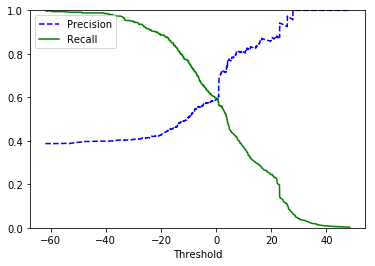


Model Precision vs Recall Curve:



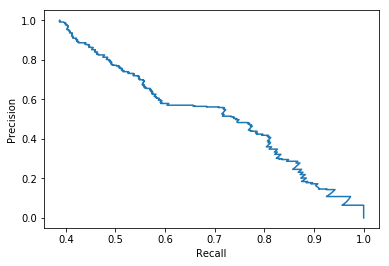


Model ROC Curve and Score:



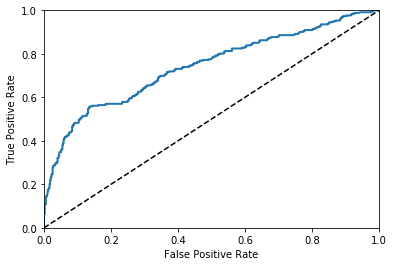


ROC AUC score: 0.7415982275056189


In [31]:
SGD_clf = SGDClassifier(random_state=42)
results_sgd = model_eval(SGD_clf,train_pp_scaled,train_labels)


Model Confusion Matrix:

[[453  96]
 [ 97 245]]

Model Precision:

0.718475073313783

Model Recall:

0.716374269005848

Model Accuracy:

0.7833894500561168

Model Precision/Recall threshold Curve:



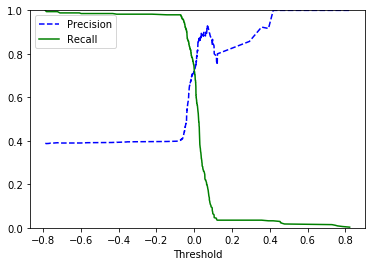


Model Precision vs Recall Curve:



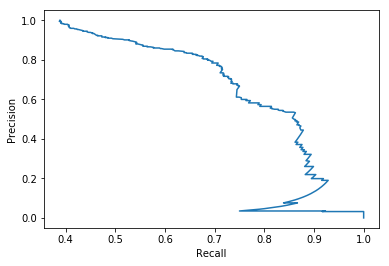


Model ROC Curve and Score:



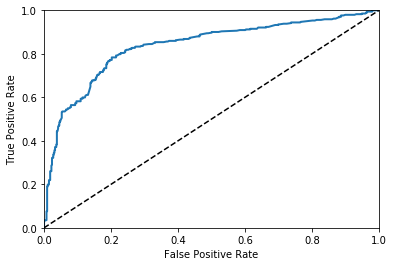


ROC AUC score: 0.8357513394901949


In [32]:
AdaB_clf = AdaBoostClassifier(random_state=42)
results_adab = model_eval(AdaB_clf,train_pp,train_labels)

Model Confusion Matrix:

[[467  82]
 [103 239]]

Model Precision:

0.7445482866043613

Model Recall:

0.6988304093567251

Model Accuracy:

0.7923681257014591

Model Precision/Recall threshold Curve:



c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0

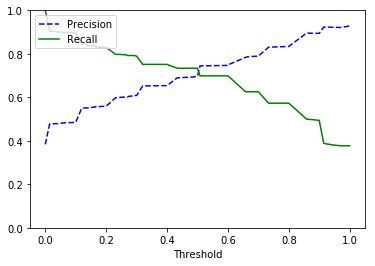


Model Precision vs Recall Curve:



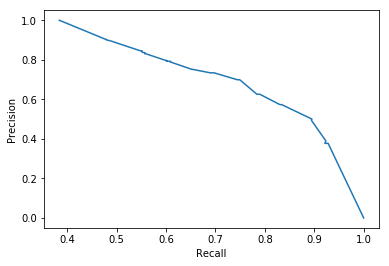


Model ROC Curve and Score:



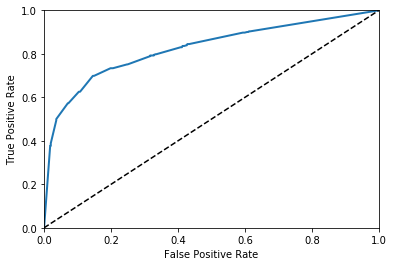


ROC AUC score: 0.8249848208864602


In [33]:
RndFrst_clf = RandomForestClassifier(random_state=42)
results_rndfrst = model_eval(RndFrst_clf,train_pp_scaled,train_labels)

Model Confusion Matrix:

[[500  49]
 [108 234]]

Model Precision:

0.8268551236749117

Model Recall:

0.6842105263157895

Model Accuracy:

0.8237934904601572

Model Precision/Recall threshold Curve:



c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

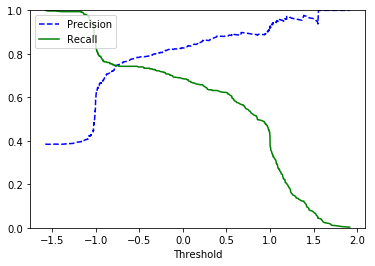


Model Precision vs Recall Curve:



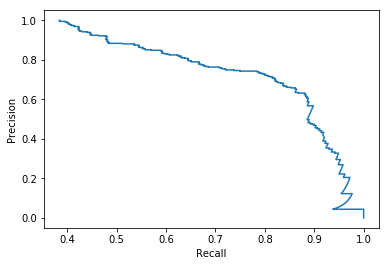


Model ROC Curve and Score:



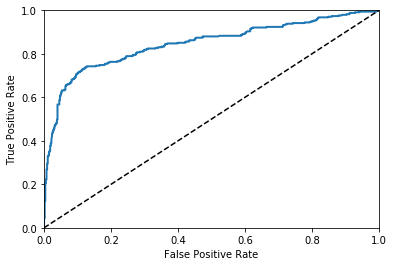


ROC AUC score: 0.8463287849252763


In [34]:
RBF_SVM_clf = SVC(kernel="rbf",random_state=42)
results_svm = model_eval(RBF_SVM_clf,train_pp_scaled,train_labels)

c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Model Confusion Matrix:

[[504  45]
 [110 232]]

Model Precision:

0.8375451263537906

Model Recall:

0.6783625730994152

Model Accuracy:



c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8215488215488215

Model Precision/Recall threshold Curve:



c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


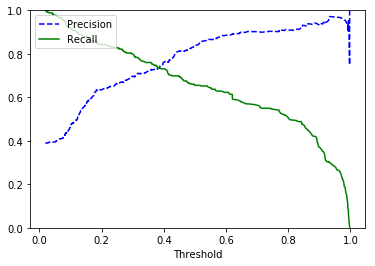


Model Precision vs Recall Curve:



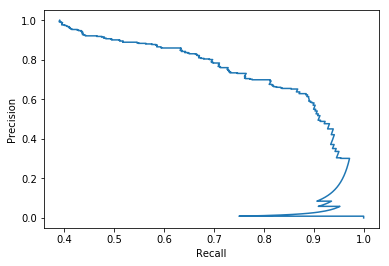


Model ROC Curve and Score:



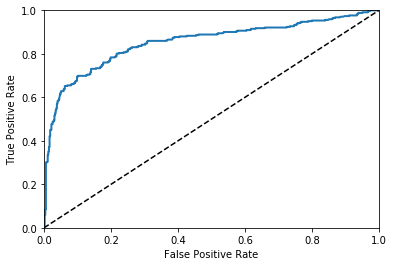


ROC AUC score: 0.8531300929920429


In [35]:
MLP_clf = MLPClassifier()
results_mlp = model_eval(MLP_clf,train_pp_scaled,train_labels)

Model Confusion Matrix:

[[455  94]
 [100 242]]

Model Precision:

0.7202380952380952

Model Recall:

0.7076023391812866

Model Accuracy:

0.7822671156004489

Model Precision/Recall threshold Curve:



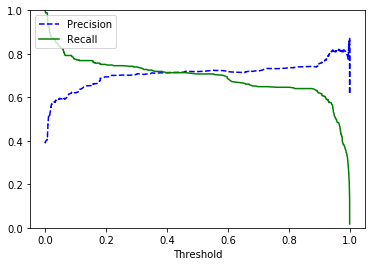


Model Precision vs Recall Curve:



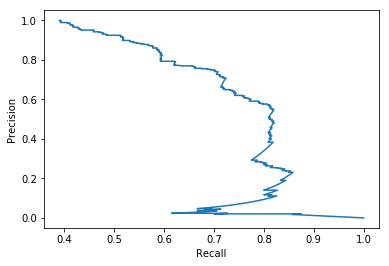


Model ROC Curve and Score:



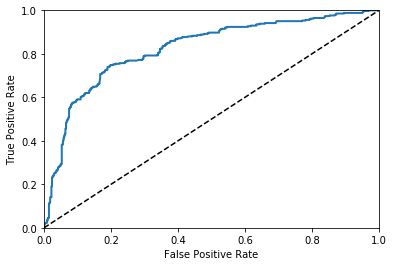


ROC AUC score: 0.8239063049244241


In [36]:
NB_clf = GaussianNB()
results_nb = model_eval(NB_clf,train_pp_scaled,train_labels)

In [37]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Random Forest', 'Naive Bayes', 'AdaBoostClassifier', 'Stochastic Gradient Descent', 'Multi-Layer Perceptron'],
    'Score': [results_svm, results_rndfrst, results_nb, results_adab, results_sgd, results_mlp]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Support Vector Machines,0.823793
5,Multi-Layer Perceptron,0.821549
1,Random Forest,0.792368
3,AdaBoostClassifier,0.783389
2,Naive Bayes,0.782267
4,Stochastic Gradient Descent,0.685746


**Notes:**

The top 4 models where chosen for further analysis and fine-tuning. 

The model performances are however not of the required standard, thus the following steps will include adding extra engineered data features which include:
    * Making use of the name attributes to extract the title of each name
    * Making use of the first class cabin names to extract first class passengers deck locations
    * Adding the SibSp and Parch attributes to provide a 'Family size' attribute
    * Adding a column indicating whether or not the passenger is a child under 13

In [38]:
RndFrst_clf.fit(train_pp,train_labels)
RndFrst_clf.feature_importances_

c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0.09367515, 0.26862004, 0.05463919, 0.03383267, 0.24852737,
       0.13211793, 0.13311786, 0.01519983, 0.00800327, 0.0122667 ])

**Quick note:**

Random Forest Feature Importance function above depicts, the currently implemented feature importances for the classification of the surviving passengers.

As can be seen, the most influential attributes are -
    * Passenger Fare,
    * Passenger Sex,
    * Passenger Age

The least influential attributes are the passenger embarking ports, but for interest sake they will be left there.

In [39]:
train_pp.loc[0:1,:]

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0


In [40]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if substring in big_string:
            return substring
    print(big_string)
    return np.nan

def phase2cleaning(data,data_original):
    data = data.join(data_original['Name'])
    data = data.join(data_original['Sex'])
    data = data.join(data_original['Cabin'])

    #creating a title column from name
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer']

    data['Title'] = data['Name'].map(lambda x: substrings_in_string(x,title_list))
    
    #replacing all titles with mr, mrs, miss, master
    def replace_titles(x):
        title=x['Title']
        if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Countess', 'Mme']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms']:
            return 'Miss'
        elif title =='Dr':
            if x['Sex']=='Male':
                return 'Mr'
            else:
                return 'Mrs'
        else:
            return title
    data['Title']=data.apply(replace_titles, axis=1)
    
    
    #Setting cabin nan values to unknown
    data.Cabin = data.Cabin.fillna('U')
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'U']
    data['Deck']=data['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
    
    #Categorize multi-label deck attributes
    cat = pd.Categorical(data['Deck'], categories = cabin_list)
    labels, unique = pd.factorize(cat)
    data['Deck'] = labels    
    
    # One hot encode multi-label title attributes
    data = pd.get_dummies(
    data, columns=["Title"], prefix=["Title_"])
        
    #Creating new family_size column
    data['Family_Size']=data['SibSp']+data['Parch']
    
    #Create new children coloumn
    data['Child'] = data['Age'] <= 13
    
    data = data.drop(['Sex','Cabin','Name'],axis=1)
    
    return data

In [41]:
train_pp2 = phase2cleaning(train_pp,train_c)
train_pp2.head()    #Final processed dataset

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S,Deck,Title__Master,Title__Miss,Title__Mr,Title__Mrs,Family_Size,Child
0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,0,1,0,1,False
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0,1,1,False
2,3,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0,0,0,False
3,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0,0,1,1,False
4,3,35.0,0,0,8.0500,0,1,0,0,1,0,0,0,1,0,0,False


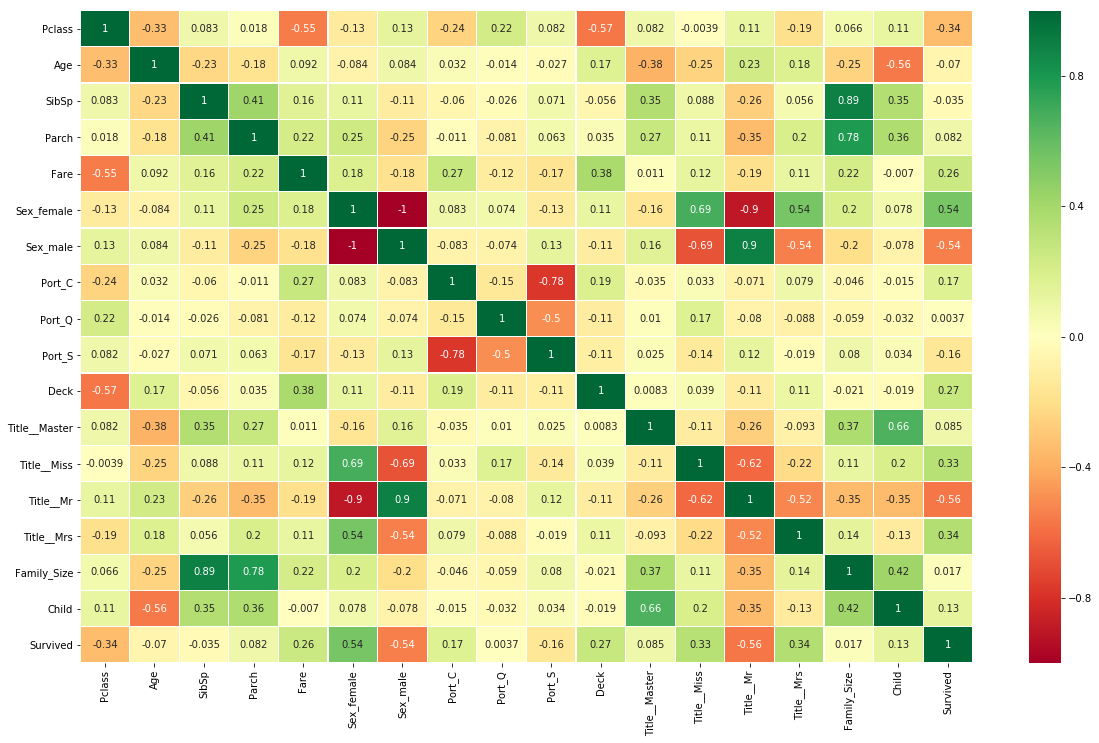

In [42]:
train_pp2_show = train_pp2.join(train_c['Survived'])
sns.heatmap(train_pp2_show.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [43]:
RndFrst_clf.fit(train_pp2,train_labels)
RndFrst_clf.feature_importances_

array([0.06489712, 0.19418592, 0.04504927, 0.01721296, 0.21396804,
       0.13749892, 0.09745718, 0.00985829, 0.00832113, 0.01289067,
       0.05069976, 0.01204183, 0.01506088, 0.06747795, 0.00728612,
       0.03729016, 0.00880382])

**Quick Note:**

From the above feature correlation heat-map and randforest feature importances, it is evident that there are some feature which firstly relate closely to other features, thus possibly making them redundant, these include:
    * Title Mr/Mrs vs Sex Male/Female
    * Family Size vs SibSp/Parch
    * Title Master vs Child
    
All these features indicated an above 65% correlation between them, the highest of that being between Title Mr vs Sex Male having a 90% correlation. The other correlations were however all under 70%, thus it is deemed acceptable and since the only thing a redundant feature will influence is the training and predict time of the model, it was deemed a negligible effect.

From the feature importances, as discussed before, there are features that play a very small role in the classification process, which include:
    * Child attribute,
    * Embarked attributes,
    * Some of the title attributes

The effects of these attributes on other models are however unknown, thus all these features were deemed acceptable.

In [44]:
#train_pp2 = train_pp2_c.drop(['Title__Mr','Title__Mrs','Title__Master','Title__Miss'],axis=1)
#Scale data
train_pp2_scaled = scaler.fit_transform(train_pp2)


c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [45]:
train_pp2.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S,Deck,Title__Master,Title__Miss,Title__Mr,Title__Mrs,Family_Size,Child
0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,0,1,0,1,False
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0,1,1,False
2,3,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0,0,0,False
3,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0,0,1,1,False
4,3,35.0,0,0,8.0500,0,1,0,0,1,0,0,0,1,0,0,False


c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol 

Model Confusion Matrix:

[[441 108]
 [129 213]]

Model Precision:

0.6635514018691588

Model Recall:

0.6228070175438597

Model Accuracy:

0.734006734006734

Model Precision/Recall threshold Curve:



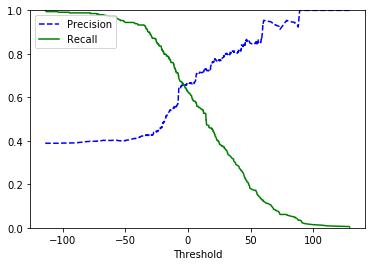


Model Precision vs Recall Curve:



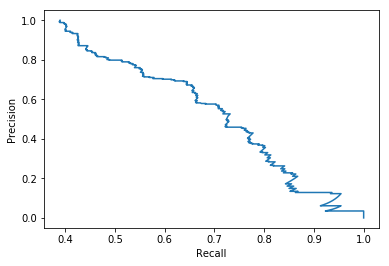


Model ROC Curve and Score:



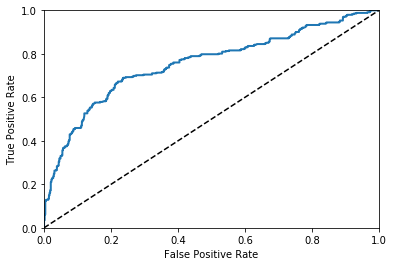


ROC AUC score: 0.7546336241331928


In [46]:
results_sgd = model_eval(SGD_clf,train_pp2_scaled,train_labels)

Model Confusion Matrix:

[[456  93]
 [ 77 265]]

Model Precision:

0.7402234636871509

Model Recall:

0.7748538011695907

Model Accuracy:

0.809203142536476

Model Precision/Recall threshold Curve:



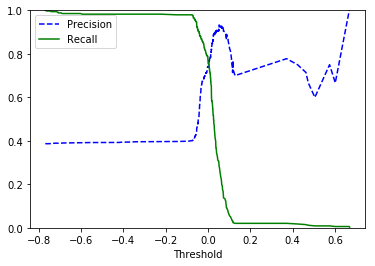


Model Precision vs Recall Curve:



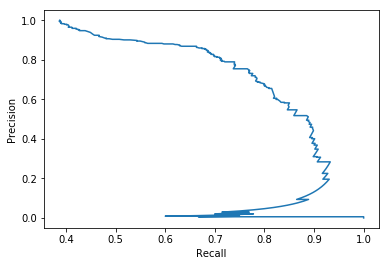


Model ROC Curve and Score:



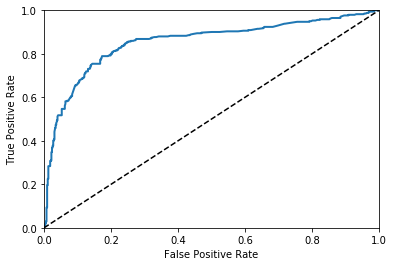


ROC AUC score: 0.8535641623792329


In [47]:
results_adab = model_eval(AdaB_clf,train_pp2,train_labels)

Model Confusion Matrix:

[[478  71]
 [101 241]]

Model Precision:

0.7724358974358975

Model Recall:

0.7046783625730995

Model Accuracy:

0.8069584736251403

Model Precision/Recall threshold Curve:



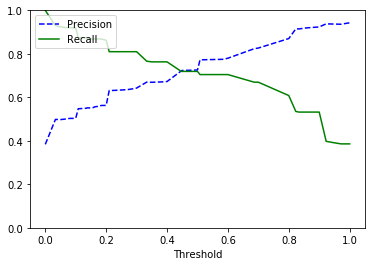


Model Precision vs Recall Curve:



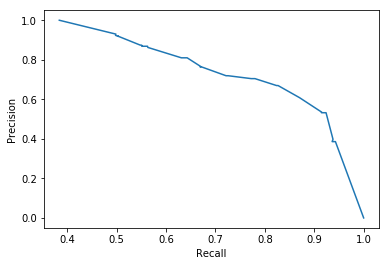


Model ROC Curve and Score:



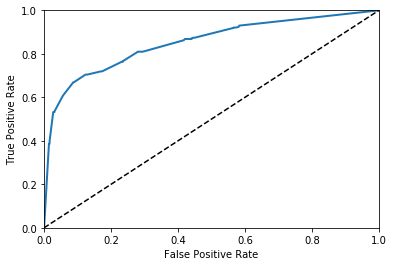


ROC AUC score: 0.8512979473577691


In [48]:
results_rndfrst = model_eval(RndFrst_clf,train_pp2_scaled,train_labels)

Model Confusion Matrix:

[[491  58]
 [ 90 252]]

Model Precision:

0.8129032258064516

Model Recall:

0.7368421052631579

Model Accuracy:

0.8338945005611672

Model Precision/Recall threshold Curve:



c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

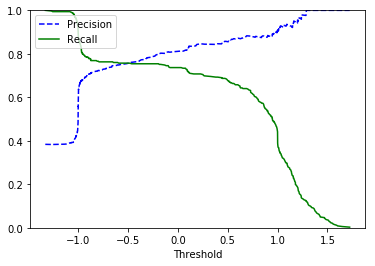


Model Precision vs Recall Curve:



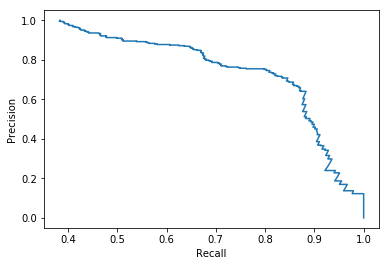


Model ROC Curve and Score:



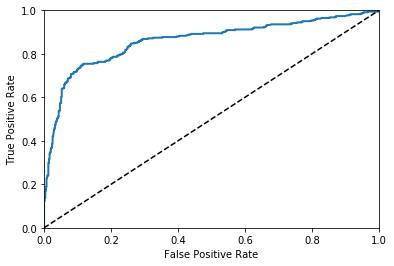


ROC AUC score: 0.8600352581514503


In [49]:
results_svm = model_eval(RBF_SVM_clf,train_pp2_scaled,train_labels)

c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Model Confusion Matrix:

[[500  49]
 [106 236]]

Model Precision:

0.8280701754385965

Model Recall:

0.6900584795321637

Model Accuracy:



c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8226711560044894

Model Precision/Recall threshold Curve:



c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


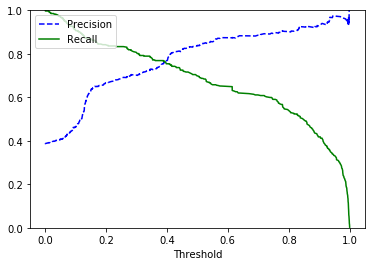


Model Precision vs Recall Curve:



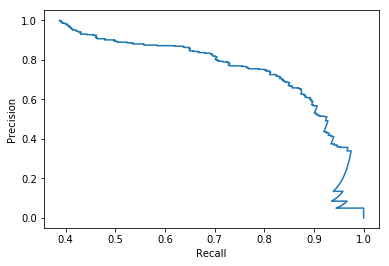


Model ROC Curve and Score:



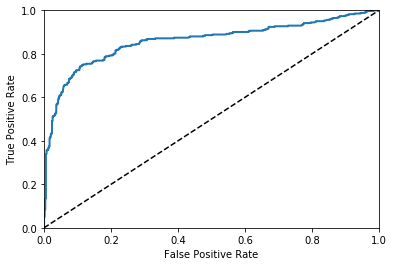


ROC AUC score: 0.8592150534198277


In [50]:
results_mlp = model_eval(MLP_clf,train_pp2_scaled,train_labels)

Model Confusion Matrix:

[[440 109]
 [ 78 264]]

Model Precision:

0.707774798927614

Model Recall:

0.7719298245614035

Model Accuracy:

0.7901234567901234

Model Precision/Recall threshold Curve:



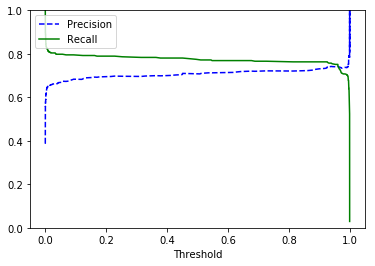


Model Precision vs Recall Curve:



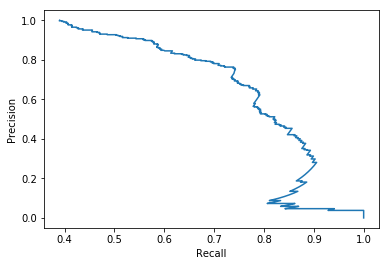


Model ROC Curve and Score:



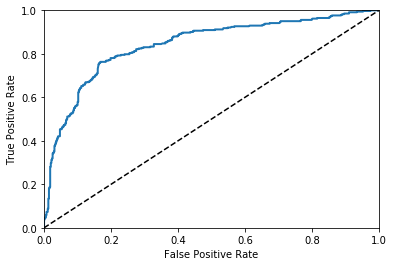


ROC AUC score: 0.8424008564215639


In [51]:
results_nb = model_eval(NB_clf,train_pp2_scaled,train_labels)

In [52]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Random Forest', 'Naive Bayes', 'AdaBoostClassifier', 'Stochastic Gradient Descent', 'Multi-Layer Perceptron'],
    'Score': [results_svm, results_rndfrst, results_nb, results_adab, results_sgd, results_mlp]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Support Vector Machines,0.833895
5,Multi-Layer Perceptron,0.822671
3,AdaBoostClassifier,0.809203
1,Random Forest,0.806958
2,Naive Bayes,0.790123
4,Stochastic Gradient Descent,0.734007


**Notes**

From these results, unfortunately there was only a slight increase in performance, but the support vector machine did take the number one spot.

Will be analyzed later.

Only the top 4 will under-go hyper-parameter tuning.

**Hyper-Parameter Tuning**

In [53]:
model = SVC()
param_grid = {'kernel': ['rbf','poly'],
              'gamma': [0.02,0.04,0.1,0.2,1],
              'C': [0.01,1,2,5,7,8,10]}

modelsvm = GridSearchCV(model, param_grid=param_grid,
                        cv=5, scoring="accuracy", n_jobs=4, verbose=1)


In [110]:
modelsvm.fit(copy_scaled, train_labels)

print(modelsvm.best_estimator_)

# Best score
print(modelsvm.best_score_)

c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 70 candidates, totalling 350 fits
SVC(C=8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.02, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8282828282828283


[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:   25.5s finished


In [108]:
model = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
            max_iter=-1, probability=False, random_state=None, shrinking=True,
            tol=0.001, verbose=False)

copy = train_pp2.drop(["Title__Mrs","Title__Mr","Title__Miss","Title__Master","Family_Size","Child"],axis=1)
copy_scaled = scaler.fit_transform(copy)

accuracy = cross_val_score(model, copy_scaled, train_labels, cv=5, scoring="accuracy")
print(accuracy.mean())

0.8136881615526278


c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
efs1 = EFS(modelsvm, min_features=16, max_features=17,
           scoring='accuracy', print_progress=True, cv=5, n_jobs=-1)

modelsvm_best = efs1.fit(train_pp2_scaled, train_labels)

In [92]:
model = MLPClassifier()
param_grid = {'solver': ['adam'],
              'max_iter': [400,600,800,1000],
              'alpha':  10.0 ** -np.arange(1, 10),
              'hidden_layer_sizes':np.arange(10, 15), 
              'random_state':[8,42]}

modelmlp = GridSearchCV(model, param_grid=param_grid,
                        cv=5, scoring="accuracy", n_jobs=4, verbose=1)

modelmlp.fit(train_pp2_scaled, train_labels)

print(modelmlp.best_estimator_)

# Best score
print(modelmlp.best_score_)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   58.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 1800 out of 1800 | elapsed:  4.2min finished


MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=13, learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=8, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
0.8327721661054994


c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [126]:
model = MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=13, learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=8, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

copy = train_pp2.drop(["SibSp"],axis=1)
copy_scaled = scaler.fit_transform(copy)

accuracy = cross_val_score(model, copy_scaled, train_labels, cv=5, scoring="accuracy")
print(accuracy.mean())

c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum

0.8283518932458372


In [86]:
model = RandomForestClassifier()
n_estim = range(100, 1000, 100)

# Search grid for optimal parameters
param_grid = {"n_estimators": n_estim,
             "max_features": ['log2','auto'],
             "criterion": ['entropy','gini']}


modelrf = GridSearchCV(model, param_grid=param_grid,
                        cv=5, scoring="accuracy", n_jobs=4, verbose=1)

modelrf.fit(train_pp2_scaled, train_labels)


# Best score
print(modelrf.best_score_)

# best estimator
modelrf.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  63 tasks      | elapsed:    7.0s


0.8170594837261503


[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   22.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
model = AdaBoostClassifier()

# Search grid for optimal parameters
param_grid = {"n_estimators": range(100, 1000, 100),
              'random_state':[4,6,8,42],
               'learning_rate': range(1,10,1)}


modeladab = GridSearchCV(model, param_grid=param_grid,
                        cv=5, scoring="accuracy", n_jobs=-1, verbose=1)

modeladab.fit(train_pp2_scaled, train_labels)


# Best score
print(modeladab.best_score_)

# best estimator
modeladab.best_estimator_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  2.1min finished
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8237934904601572


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=900, random_state=4)

In [997]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Random Forest', 'AdaBoostClassifier', 'Multi-Layer Perceptron'],
    'Score': [modelsvm.best_score_,modelrf.best_score_, modeladab.best_score_, modelmlp.best_score_]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Multi-Layer Perceptron,0.837262
0,Support Vector Machines,0.833895
2,AdaBoostClassifier,0.821549
1,Random Forest,0.805836


**Notes:**

It is evident that the Multi-Layer Perceptron performs the best on the dataset after hyper-parameter tuning. This is thus chosen as the final model.



**Final Model**

In [112]:
#Prepare test dataset
test_pp = phase1cleaning(test)
test_pp2 = phase2cleaning(test_pp,test_c)
#Scale data
test_pp2_scaled = scaler.fit_transform(test_pp2)

test_pp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
Pclass           418 non-null int64
Age              418 non-null float64
SibSp            418 non-null int64
Parch            418 non-null int64
Fare             418 non-null float64
Sex_female       418 non-null uint8
Sex_male         418 non-null uint8
Port_C           418 non-null uint8
Port_Q           418 non-null uint8
Port_S           418 non-null uint8
Deck             418 non-null int64
Title__Master    418 non-null uint8
Title__Miss      418 non-null uint8
Title__Mr        418 non-null uint8
Title__Mrs       418 non-null uint8
Family_Size      418 non-null int64
Child            418 non-null bool
dtypes: bool(1), float64(2), int64(5), uint8(9)
memory usage: 27.0 KB


c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [120]:
final_model = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
            max_iter=-1, probability=False, random_state=None, shrinking=True,
            tol=0.001, verbose=False)

copy_train = train_pp2.drop(["Title__Mrs"],axis=1)
copy_train_scaled = scaler.fit_transform(copy_train)

copy_test = test_pp2.drop(["Title__Mrs"],axis=1)
copy_test_scaled = scaler.fit_transform(copy_test)

final_model.fit(copy_train_scaled, train_labels)
survived_test_predict = final_model.predict(copy_test_scaled)

survived_test_predict

c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\daniel\appdata\local\continuum\anaconda3\envs\ada\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [1061]:
from sklearn.neural_network import MLPClassifier
final_model = SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
                  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
                  max_iter=-1, probability=False, random_state=None, shrinking=True,
                  tol=0.001, verbose=False)

final_model.fit(train_pp2_scaled, train_labels)
survived_test_predict = final_model.predict(test_pp2_scaled)

In [121]:
submission = pd.DataFrame({"PassengerId": test_c["PassengerId"],
                           "Survived": survived_test_predict})

In [122]:
filename = 'Titanic Predictions 1.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: Titanic Predictions 1.csv
